# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import janitor as jn

from seaborn import diverging_palette

In [2]:
from sklearn import (
    ensemble,
    model_selection,
    preprocessing,
    tree
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    cohen_kappa_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)
from yellowbrick.model_selection import (
    LearningCurve 
)

from imblearn.over_sampling import (
    SMOTE, ADASYN
)

# Load dataset

In [3]:
import pandas as pd

df = pd.read_csv('bank_marketing_dataset.csv')
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Create the target

In [5]:
target = [
    1 if i == 'yes'
    else 0
    for i in df['subscribed']
]

df['target'] = target
df['target'].value_counts()

0    36548
1     4640
Name: target, dtype: int64

In [6]:
df.drop('subscribed', axis=1, inplace=True)

# Data clean up

In [11]:
#df.drop(['duration'],
#       axis=1,
#       inplace=True)

# this attribute highly affects the output target (e.g., if duration=0 then y='no'). 

### Correlations

In [7]:
numerical_cols_c = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

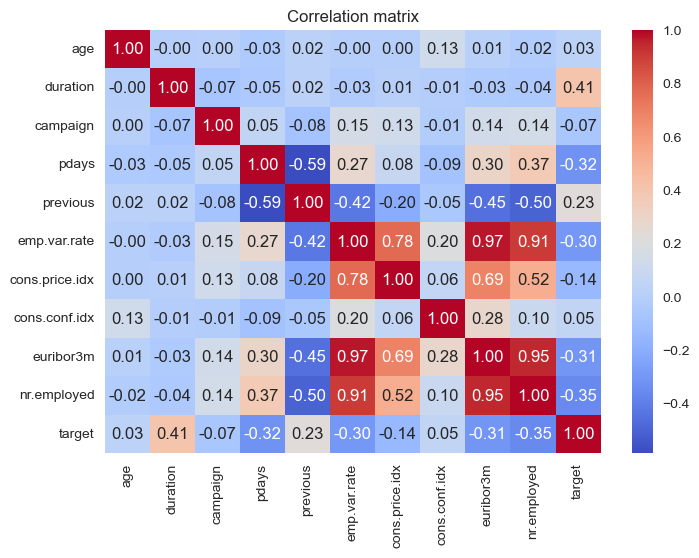

In [8]:
# Correlation matrix
corr = df[numerical_cols_c].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix")
plt.show()

In [9]:
# nr.employed, euribor3m and emp.var.rate are all highly correlated. Let's only keep nr.employed
df = df.drop(columns=['euribor3m', 'emp.var.rate'])

# Categorical encoding

In [10]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
numeric_cols

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'nr.employed', 'target'],
      dtype='object')

In [11]:
categorical_cols = df.select_dtypes(include=["object"]).columns
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

### Label encode for categories that have less than two values

In [12]:
from sklearn import preprocessing

count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print(col)

print('%d columns were label encoded.' % count)

contact
1 columns were label encoded.


Now, contact = 1 if telephone and 0 if cellular

### One-hot encoding the rest of categorical columns

In [13]:
df = pd.get_dummies(df)
print(df.shape)

(41188, 61)


In [14]:
for col in df.columns:
    print(col)

age
contact
duration
campaign
pdays
previous
cons.price.idx
cons.conf.idx
nr.employed
target
job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
job_unknown
marital_divorced
marital_married
marital_single
marital_unknown
education_basic.4y
education_basic.6y
education_basic.9y
education_high.school
education_illiterate
education_professional.course
education_university.degree
education_unknown
default_no
default_unknown
default_yes
housing_no
housing_unknown
housing_yes
loan_no
loan_unknown
loan_yes
month_apr
month_aug
month_dec
month_jul
month_jun
month_mar
month_may
month_nov
month_oct
month_sep
day_of_week_fri
day_of_week_mon
day_of_week_thu
day_of_week_tue
day_of_week_wed
poutcome_failure
poutcome_nonexistent
poutcome_success


## Seperate features and target

In [15]:
#pip install pyjanitor
import janitor as jn

In [16]:
X, y = jn.ml.get_features_targets(df, target_columns="target")

c:\Users\olivi\anaconda3\lib\site-packages\janitor\utils.py:365: DeprecationWarning: target_columns is deprecated; use target_column_names
  warn(


## Train test split

In [17]:
X_train, X_val_test, y_train, y_val_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)

In [18]:
print(len(X_train))
print(len(X_val_test))
print(len(y_train))
print(len(y_val_test))

28831
12357
28831
12357


## Test validation split

In [19]:
X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42)

In [20]:
print(len(X_val))
print(len(X_test))
print(len(y_val))
print(len(y_test))

6178
6179
6178
6179


# Standardize data

In [21]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Evaluation Metrics

### ROC Curve

In [22]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### PR Curve

In [23]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### Classification Score

In [24]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)
        print("End of validation Result\n")

### Classification Metrics

In [25]:
def evaluation_metrics(y_actual, y_pred):
            
        precision, recall, _ = precision_recall_curve(y_actual, y_pred)
        average_precision = average_precision_score(y_actual, y_pred)
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_actual, y_pred)
        roc_auc = roc_auc_score(y_actual, y_pred)
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_actual, y_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_actual, y_pred)))

# Balance target variable

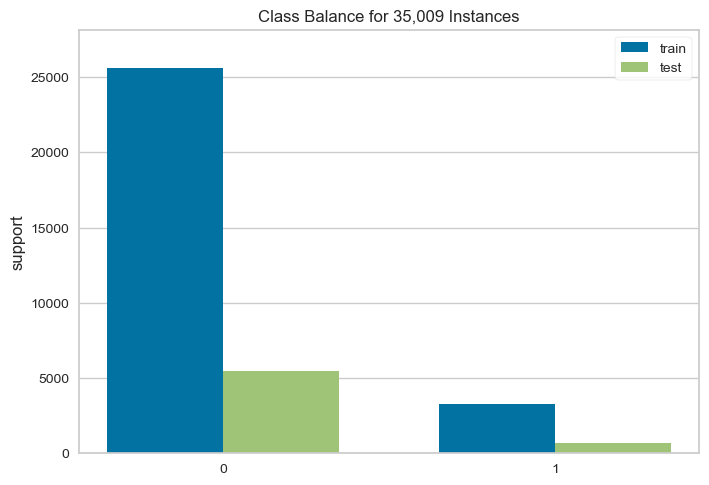

<Axes: title={'center': 'Class Balance for 35,009 Instances'}, ylabel='support'>

In [26]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Up-sample the training data

In [27]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

c:\Users\olivi\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\olivi\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


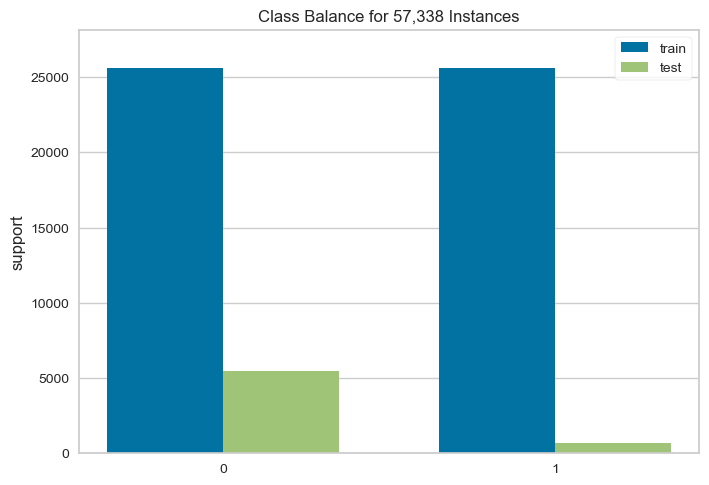

<Axes: title={'center': 'Class Balance for 57,338 Instances'}, ylabel='support'>

In [29]:
# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train_sm, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# XGBoost

In [30]:
#!pip install xgboost 
import xgboost as xgb

Validation Result:

accuracy score: 0.9147



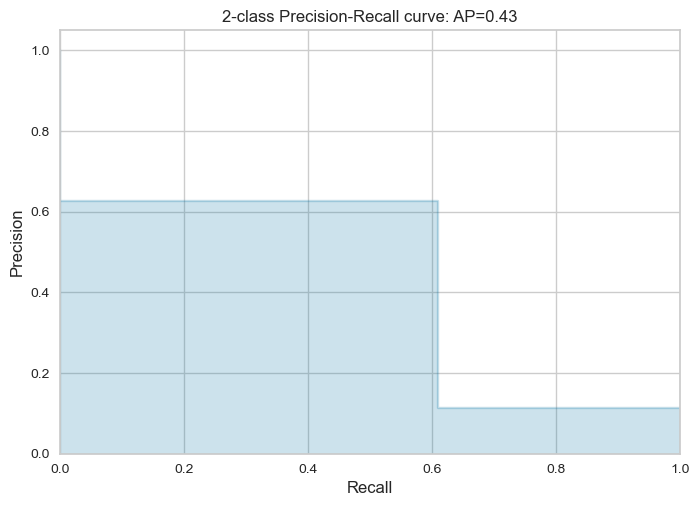

roc auc score: 0.7818911697655448



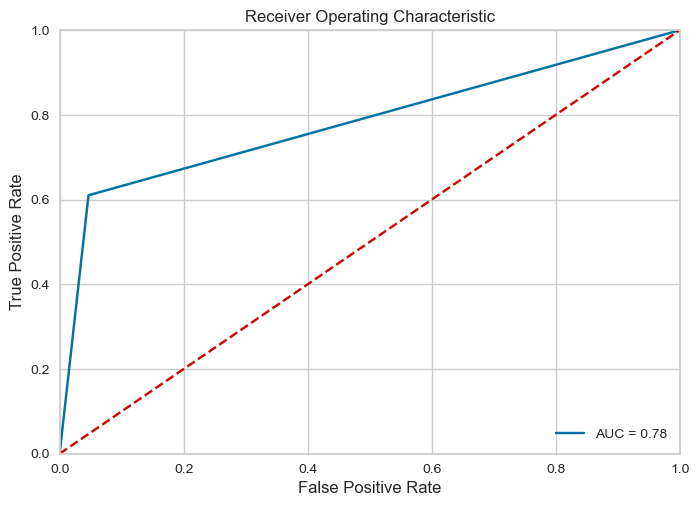

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      5480
           1       0.63      0.61      0.62       698

    accuracy                           0.91      6178
   macro avg       0.79      0.78      0.78      6178
weighted avg       0.91      0.91      0.91      6178


Confusion Matrix: 
 [[5225  255]
 [ 272  426]]

End of validation Result



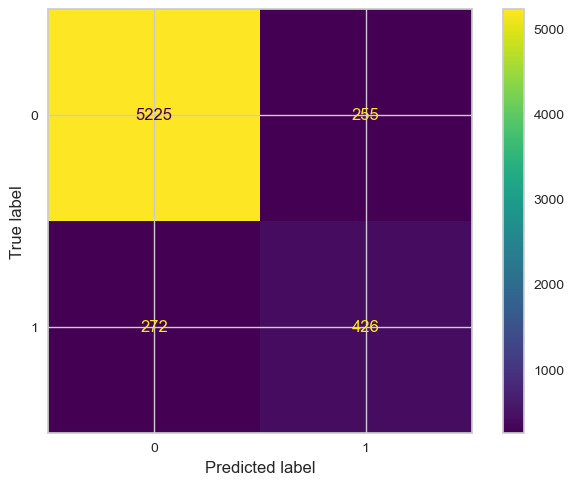

In [31]:
clf_xgb = xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0)
clf_xgb.fit(X_train_sm, y_train_sm)

clf_score(clf_xgb, X_train_sm, y_train_sm, X_val, y_val, train=False)

#### Feature importance

<Axes: >

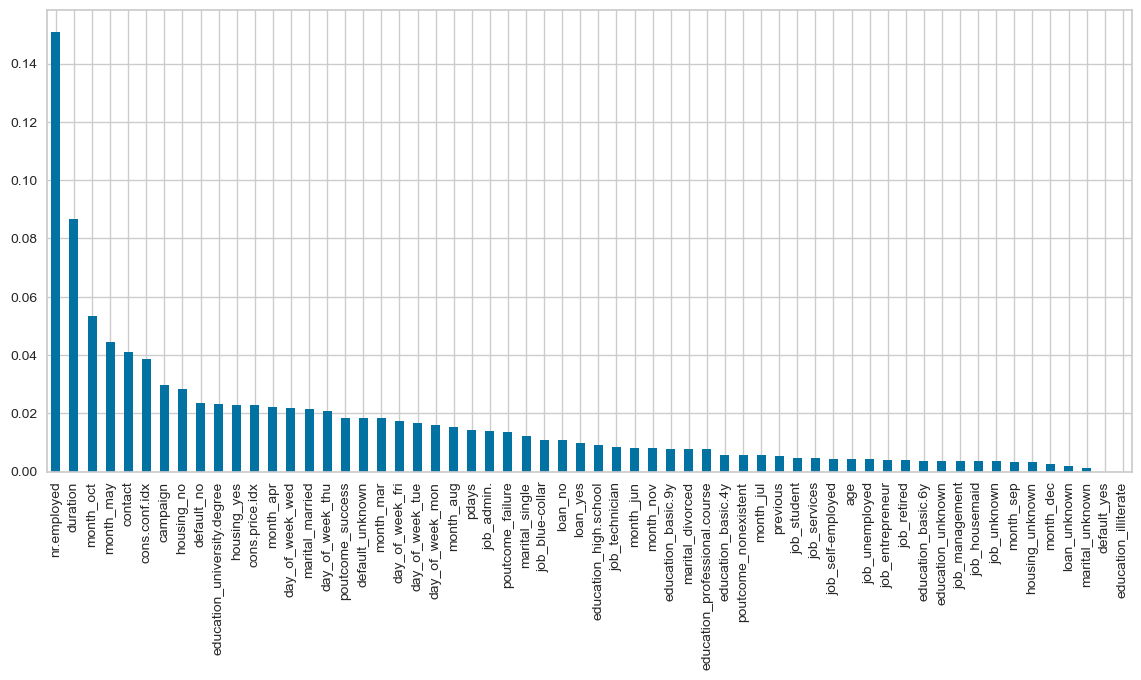

In [32]:
# Print feature importance
pd.Series(clf_xgb.feature_importances_,index = X.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (14,6))


In [ ]:
#pip install shap


     -------------------------------------- 450.3/450.3 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# SHAP

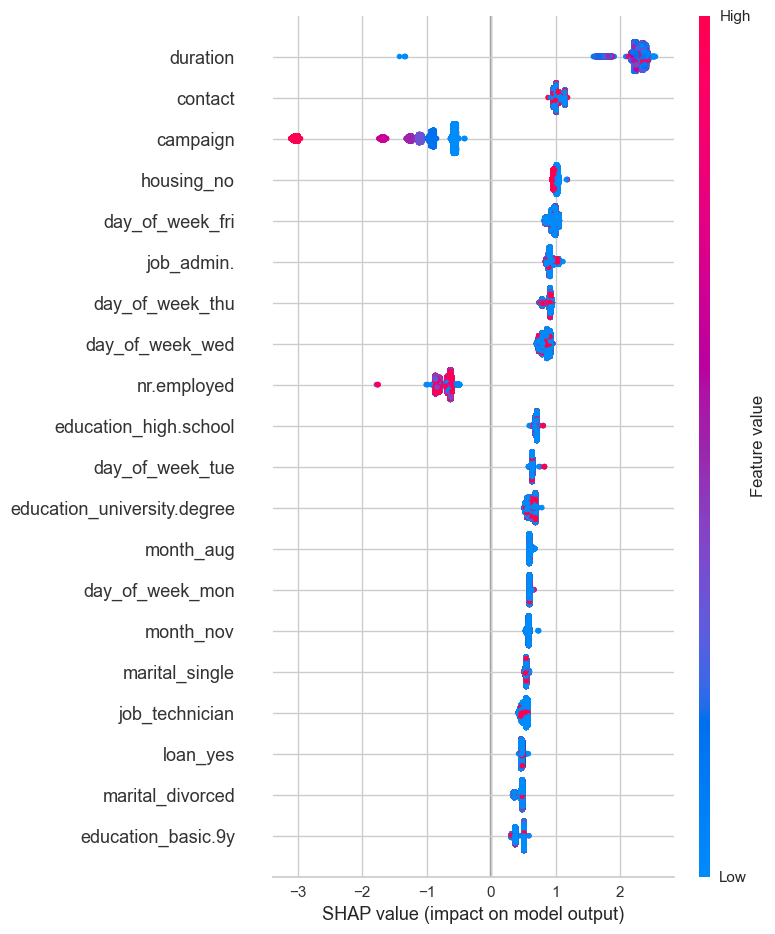

In [33]:
import shap

explainer = shap.Explainer(clf_xgb)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, feature_names=X.columns)